In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym
import math, os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
UPDATE_GLOBAL_ITER = 10
GAMMA = 0.9
MAX_EP = 4000

In [3]:
env = gym.make('CartPole-v0')
N_S = env.observation_space.shape[0]
N_A = env.action_space.n

[2018-09-30 17:53:02,993] Making new env: CartPole-v0


In [4]:
import numpy as np
def set_init(layers):
    """initialize layers with W ~ N(0, 0.1), b=0.1"""
    for layer in layers:
        nn.init.normal_(layer.weight, mean=0., std=0.1)
        nn.init.constant_(layer.bias, 0.1)

In [5]:
class Net(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(Net, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.pi1 = nn.Linear(s_dim, 100)
        self.pi2 = nn.Linear(100, a_dim)
        self.v1 = nn.Linear(s_dim, 100)
        self.v2 = nn.Linear(100, 1)
        set_init([self.pi1, self.pi2, self.v1, self.v2])
        self.distribution = torch.distributions.Categorical  # 離散分布
        
    def forward(self, x):
        pi1 = F.relu(self.pi1(x))
        logits = self.pi2(pi1)
        v1 = F.relu(self.v1(x))
        values = self.v2(v1)
        return logits, values
    
    def choose_action(self, s):
        self.eval()  # evaluation mode
        logits, _ = self.forward(s)
        prob = F.softmax(logits, dim=1).data
        m = self.distribution(prob)
        return m.sample().numpy()[0]
    
    def loss_func(self, s, a, v_t):
        self.train()  # training mode
        logits, values = self.forward(s)
        td = v_t - values
        c_loss = td.pow(2)  # MSE
        
        probs = F.softmax(logits, dim=1)
        m = self.distribution(probs)
        exp_v = m.log_prob(a) * td.detach().squeeze()  # calc grads only for actor
        # TODO: v_tではなくtd?
        a_loss = -exp_v
        total_loss = (c_loss + a_loss).mean()
        return total_loss

In [12]:
def v_wrap(np_array, dtype=np.float32):
    """ndarray -> torch.Tensor(dtype=dtype)"""
    if np_array.dtype != dtype:
        np_array = np_array.astype(dtype)
    return torch.from_numpy(np_array)

In [6]:
def push_and_pull(opt, lnet, gnet, done, s_, bs, ba, br, gamma):
    # value of next state s_
    if done:
        v_s_ = 0.  # terminal
    else:
        v_s_ = lnet.forward(v_wrap(s_[None, :]))[-1].data.numpy()[0, 0]  # bootstrap
        
    buffer_v_target = []
    for r in br[::-1]:  # reverse buffer r
        v_s_ = r + gamma * v_s_
        buffer_v_target.append(v_s_)
    buffer_v_target.reverse()
        
    loss = lnet.loss_func(
        v_wrap(np.vstack(bs)),
        v_wrap(np.array(ba), dtype=np.int64) if ba[0].dtype==np.int64 else v_wrap(np.vstack(ba)),
        v_wrap(np.array(buffer_v_target)[:, None]) #??
    )
    
    # calclate local gradients and push local parameters to global
    opt.zero_grad()
    loss.backward()
    for lp, gp in zip(lnet.parameters(), gnet.parameters()):
        gp._grad = lp.grad
    opt.step()  # update by shared Adam
    
    # pull global parameters
    lnet.load_state_dict(gnet.state_dict())

In [16]:
def record(global_ep, global_ep_r, ep_r, res_queue, name):
    with global_ep.get_lock():
        global_ep.value += 1
    with global_ep_r.get_lock():
        if global_ep_r.value == 0.:
            global_ep_r.value = ep_r  # 最初の更新者が基準？
        else:
            global_ep_r.value = global_ep_r.value * 0.99 + ep_r * 0.01
    res_queue.put(global_ep_r.value)    
    print(
        name,
        "Ep:", global_ep.value,
        "| Ep_r: {:.0f}".format(global_ep_r.value),
    )

In [14]:
class Worker(mp.Process):  # mp.Process を継承
    def __init__(self, gnet, opt, global_ep, global_ep_r, res_queue, name):
        # global_ep: mp.Value; global episodeのカウンタ
        # global_ep_r: mp.Value; local episodeのrewardをまぜる？？
        # res_queue: mp.Queue; global_ep_rの値を保存
        super(Worker, self).__init__()
        self.name = 'w{}'.format(name)
        self.g_ep, self.g_ep_r, self.res_queue = global_ep, global_ep_r, res_queue
        self.gnet, self.opt = gnet, opt  # global network, optimizer
        self.lnet = Net(N_S, N_A)  # local network
        self.env = gym.make('CartPole-v0').unwrapped  # envの内部にアクセスできる？
        
    def run(self):
        total_step = 1
        while self.g_ep.value < MAX_EP:
            s = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0.
            while True:
                #if self.name == 'w0':
                #    self.env.render()
                a = self.lnet.choose_action(v_wrap(s[None, :]))  # Noneはbatchdim??
                s_, r, done, _ = self.env.step(a)
                if done:
                    r = -1  # 0ではない?
                ep_r += r
                buffer_a.append(a)
                buffer_s.append(s)
                buffer_r.append(r)
                
                if total_step % UPDATE_GLOBAL_ITER == 0 or done:
                    # update global and assign to local net
                    push_and_pull(self.opt, self.lnet, self.gnet, done, s_, buffer_s, buffer_a, buffer_r, GAMMA)
                    buffer_s, buffer_a, buffer_r = [], [], []
                    
                    if done:
                        # done and print information
                        record(self.g_ep, self.g_ep_r, ep_r, self.res_queue, self.name)
                        break
                s = s_
                total_step += 1
        self.res_queue.put(None)

In [9]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.9), eps=1e-8, weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        # state initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                # share in memory
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

In [10]:
mp.cpu_count()

4

[2018-09-30 18:00:20,925] Making new env: CartPole-v0
[2018-09-30 18:00:20,931] Making new env: CartPole-v0
[2018-09-30 18:00:20,935] Making new env: CartPole-v0
[2018-09-30 18:00:20,939] Making new env: CartPole-v0


w0 Ep: 1 | Ep_r: 17
w1 Ep: 2 | Ep_r: 17
w0 Ep: 4 | Ep_r: 17
w2 Ep: 3 | Ep_r: 17
w1 Ep: 6 | Ep_r: 17
w3 Ep: 5 | Ep_r: 17
w0 Ep: 7 | Ep_r: 17
w2 Ep: 8 | Ep_r: 17
w3 Ep: 10 | Ep_r: 17
w1 Ep: 9 | Ep_r: 17
w0 Ep: 11 | Ep_r: 17
w3 Ep: 12 | Ep_r: 17
w2 Ep: 13 | Ep_r: 17
w3 Ep: 14 | Ep_r: 17
w1 Ep: 15 | Ep_r: 17
w0 Ep: 16 | Ep_r: 17
w2 Ep: 17 | Ep_r: 17
w3 Ep: 18 | Ep_r: 17
w1 Ep: 19 | Ep_r: 17
w0 Ep: 20 | Ep_r: 17
w3 Ep: 21 | Ep_r: 17
w2 Ep: 22 | Ep_r: 17
w0 Ep: 23 | Ep_r: 17
w2 Ep: 24 | Ep_r: 17
w1 Ep: 25 | Ep_r: 17
w3 Ep: 26 | Ep_r: 17
w0 Ep: 27 | Ep_r: 17
w1 Ep: 28 | Ep_r: 17
w3 Ep: 29 | Ep_r: 17
w2 Ep: 30 | Ep_r: 17
w0 Ep: 31 | Ep_r: 17
w2 Ep: 32 | Ep_r: 17
w1 Ep: 33 | Ep_r: 17
w2 Ep: 34 | Ep_r: 17
w3 Ep: 35 | Ep_r: 18
w0 Ep: 36 | Ep_r: 18
w2 Ep: 37 | Ep_r: 18
w1 Ep: 38 | Ep_r: 18
w3 Ep: 39 | Ep_r: 17
w0 Ep: 40 | Ep_r: 17
w2 Ep: 41 | Ep_r: 18
w3 Ep: 42 | Ep_r: 18
w0 Ep: 43 | Ep_r: 18
w1 Ep: 44 | Ep_r: 18
w3 Ep: 45 | Ep_r: 18
w2 Ep: 46 | Ep_r: 18
w0 Ep: 47 | Ep_r: 18
w3 Ep: 48 | Ep_r: 18
w

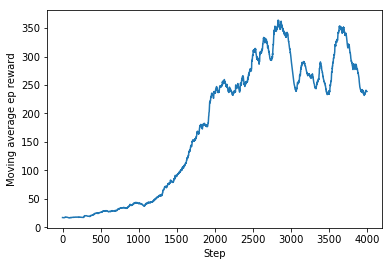

In [17]:
if __name__ == '__main__':
    gnet = Net(N_S, N_A)
    gnet.share_memory()
    opt = SharedAdam(gnet.parameters(), lr=0.0001)
    global_ep = mp.Value('i', 0)
    global_ep_r = mp.Value('d', 0.)
    res_queue = mp.Queue()
    
    # parallel training
    workers = [Worker(gnet, opt, global_ep, global_ep_r, res_queue, i) for i in range(mp.cpu_count())]
    [w.start() for w in workers]
    res = []  # record episode reward to plot
    while True:
        r = res_queue.get()
        if r is not None:
            res.append(r)
        else:
            break
    [w.join() for w in workers] #??
    
    import matplotlib.pyplot as plt
    plt.plot(res)
    plt.ylabel('Moving average ep reward')
    plt.xlabel('Step')
    plt.show()